In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import os
from hdpgpc.get_data import compute_estimators_LDS
import math
from scipy.fft import fft
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import importlib
import pickle
import hdpgpc.GPI_HDP as hdpgp
import re
from datetime import datetime, timedelta
import time

/home/adrian.perez/Documents/OceanWave/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from hdpgpc.util_plots import print_results
import hdpgpc.util_plots as up
importlib.reload(up)

<module 'hdpgpc.util_plots' from '/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/hdpgpc/util_plots.py'>

---

### Datos NDBC

In [3]:
cwd = os.path.dirname(os.getcwd())
data_path = os.path.join(os.path.join(cwd, 'data'), 'ocean')
df = pd.read_csv(os.path.join(data_path, "nbdc.txt"), delim_whitespace=True, header=0)
df = df.iloc[:, 5:]

/tmp/ipykernel_128784/1463893536.py:3: FutureWarning:

The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead



In [4]:
freq = df.columns
freq = freq.astype(float)

data = df.to_numpy()
data = data[:, :, np.newaxis]
data.shape
num_samples, num_obs_per_sample, num_outputs = data.shape

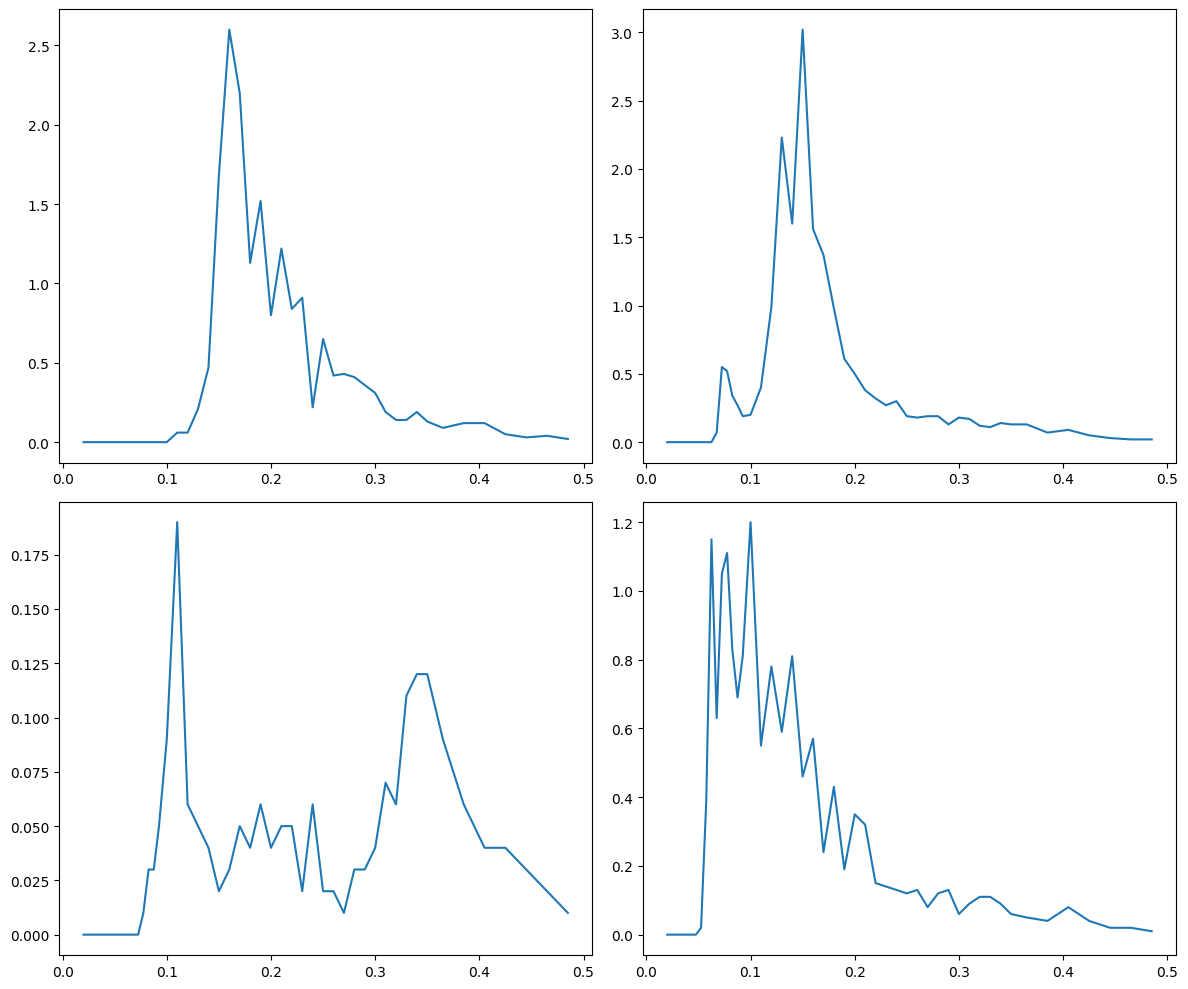

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Gráfica 1
axs[0, 0].plot(freq, data[0, :, 0])

# Gráfica 2
axs[0, 1].plot(freq, data[127, :, 0])

# Gráfica 3
axs[1, 0].plot(freq, data[35, :, 0])

# Gráfica 4
axs[1, 1].plot(freq, data[5923, :, 0])

# Ajustar el layout para evitar superposición
plt.tight_layout()
plt.show()

Shape of hs: (8524, 1)
How much spectra falls in the range 0.5-3.0 Hs: 8160


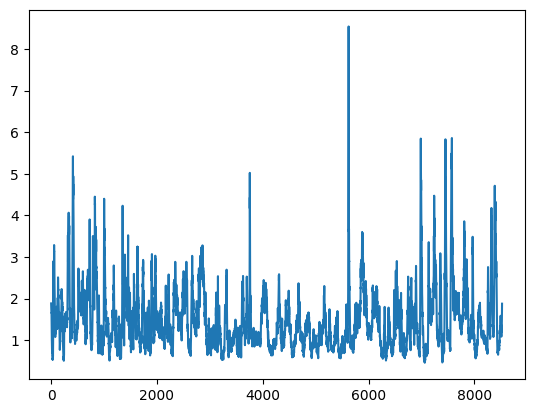

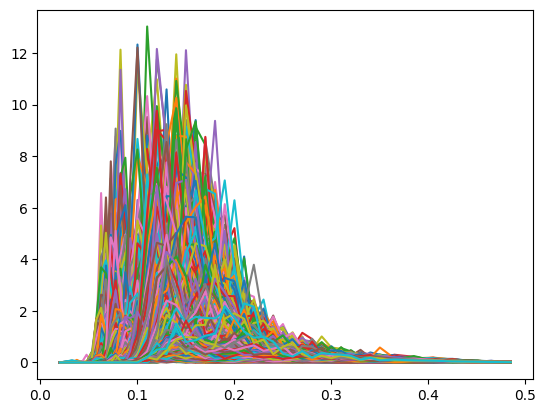

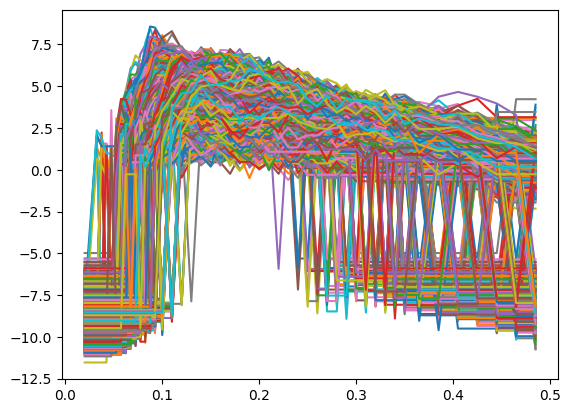

In [6]:
#Here we are going to compute the Heighs and try to filter following Hamiltons rule.
interv = np.repeat(freq[1]-freq[0], num_obs_per_sample)[:, np.newaxis]
hs = 4 * np.sqrt(data[:,:,0] @ interv)
print("Shape of hs: "+str(hs.shape))
plt.plot(hs)
chosen_indexes = np.where((hs > 0.5) & (hs < 3.0))[0]
#chosen_indexes = np.arange(0, num_samples)
print("How much spectra falls in the range 0.5-3.0 Hs: " + str(chosen_indexes.shape[0]))
plt.show()
plt.plot(freq, data[:,:,0][chosen_indexes].T)
plt.show()
lognorm_data = np.log(data + 1e-6) - np.mean(np.log(data+ 1e-6), axis=1)[:,np.newaxis,:]
plt.plot(freq, lognorm_data[:,:,0][chosen_indexes].T)
plt.show()


In [7]:
#Select indexes
data = data[chosen_indexes]
print("Shape of the data: ")
print(data.shape)

num_samples, num_obs_per_sample, num_outputs = data.shape

Shape of the data: 
(8160, 47, 1)


In [8]:
std, std_dif, bound_sigma, bound_gamma = compute_estimators_LDS(data, n_f=num_samples-1)
#Seem like these estimators are so big for this data, let's reduce them
std = std * 0.15
std_dif = std_dif * 0.05
bound_sigma = (std * 1e-7, std * 1e-1)
bound_gamma = (std_dif * 1e-9, std_dif * 1e-1)

print("Final sigma:", std)
print("Final gamma:", std_dif)
print("Final sigma bound:", bound_sigma)
print("Final gamma bound:", bound_gamma)

Sigma estimated: 0.21968792077809854
Gamma estimated: 0.21968792077809854
Final sigma: 0.03295318811671478
Final gamma: 0.010984396038904928
Final sigma bound: (3.2953188116714777e-09, 0.003295318811671478)
Final gamma bound: (1.098439603890493e-11, 0.0010984396038904928)


In [9]:
M = 2
sigma = [std * 1.0] * M
gamma = [std_dif * 1.0] * M
outputscale_ = 1.0
ini_lengthscale = 1e-2
bound_lengthscale = (1e-7, 5e-1)
samples = [0, num_obs_per_sample]
l, L = samples[0], samples[1]
# x_basis has to have the same dimension structure as data[0], in this case (171,1) but it could be (n_inducing_points, 1).
x_basis = np.atleast_2d(freq[0:100]).T
x_train = np.atleast_2d(freq[0:100]).T
print(x_train.shape)
#If x_basis is wanted to be smaller than the observations length, then the inducing points approach can be applied setting this parameter to True.
inducing_points = False
#Choose if warp is going to be applied. (In the most recent version is optimized to work with online inference, but it can be used in offline as an additional step at the end of the clustering).
warp = False
#Warp priors
noise_warp = std * 0.1
bound_noise_warp = (noise_warp * 0.1, noise_warp * 0.2)
#Warp time indexes
x_basis_warp = np.atleast_2d(np.arange(freq[0], freq[-1], freq.shape[0]/2.0, dtype=np.float64)).T

(47, 1)


Sample: 0
Main model chosen: 1
---Kernel estimated---
0.534**2 * RBF(length_scale=0.00906) + WhiteKernel(noise_level=0.00299)
Sample: 1
Main model chosen: 1
Sample: 2
Main model chosen: 1
Sample: 3
Main model chosen: 1
Sample: 4
Birth of new model:  2
Main model chosen: 2
---Kernel estimated---
0.498**2 * RBF(length_scale=0.00894) + WhiteKernel(noise_level=0.00301)
Sample: 5
Main model chosen: 2
Sample: 6
Main model chosen: 2
Sample: 7
Main model chosen: 2
Sample: 8
Main model chosen: 2
Sample: 9
Main model chosen: 2
Sample: 10
Main model chosen: 2
Sample: 11
Birth of new model:  3
Main model chosen: 3
---Kernel estimated---
0.276**2 * RBF(length_scale=0.0104) + WhiteKernel(noise_level=3.44e-07)
Sample: 12
Main model chosen: 3
Sample: 13
Main model chosen: 3
Sample: 14
Main model chosen: 3
Sample: 15
Main model chosen: 3
Sample: 16
Main model chosen: 3
Sample: 17
Main model chosen: 3
Sample: 18
Main model chosen: 3
Sample: 19
Main model chosen: 3
Sample: 20
Main model chosen: 3
Sample:

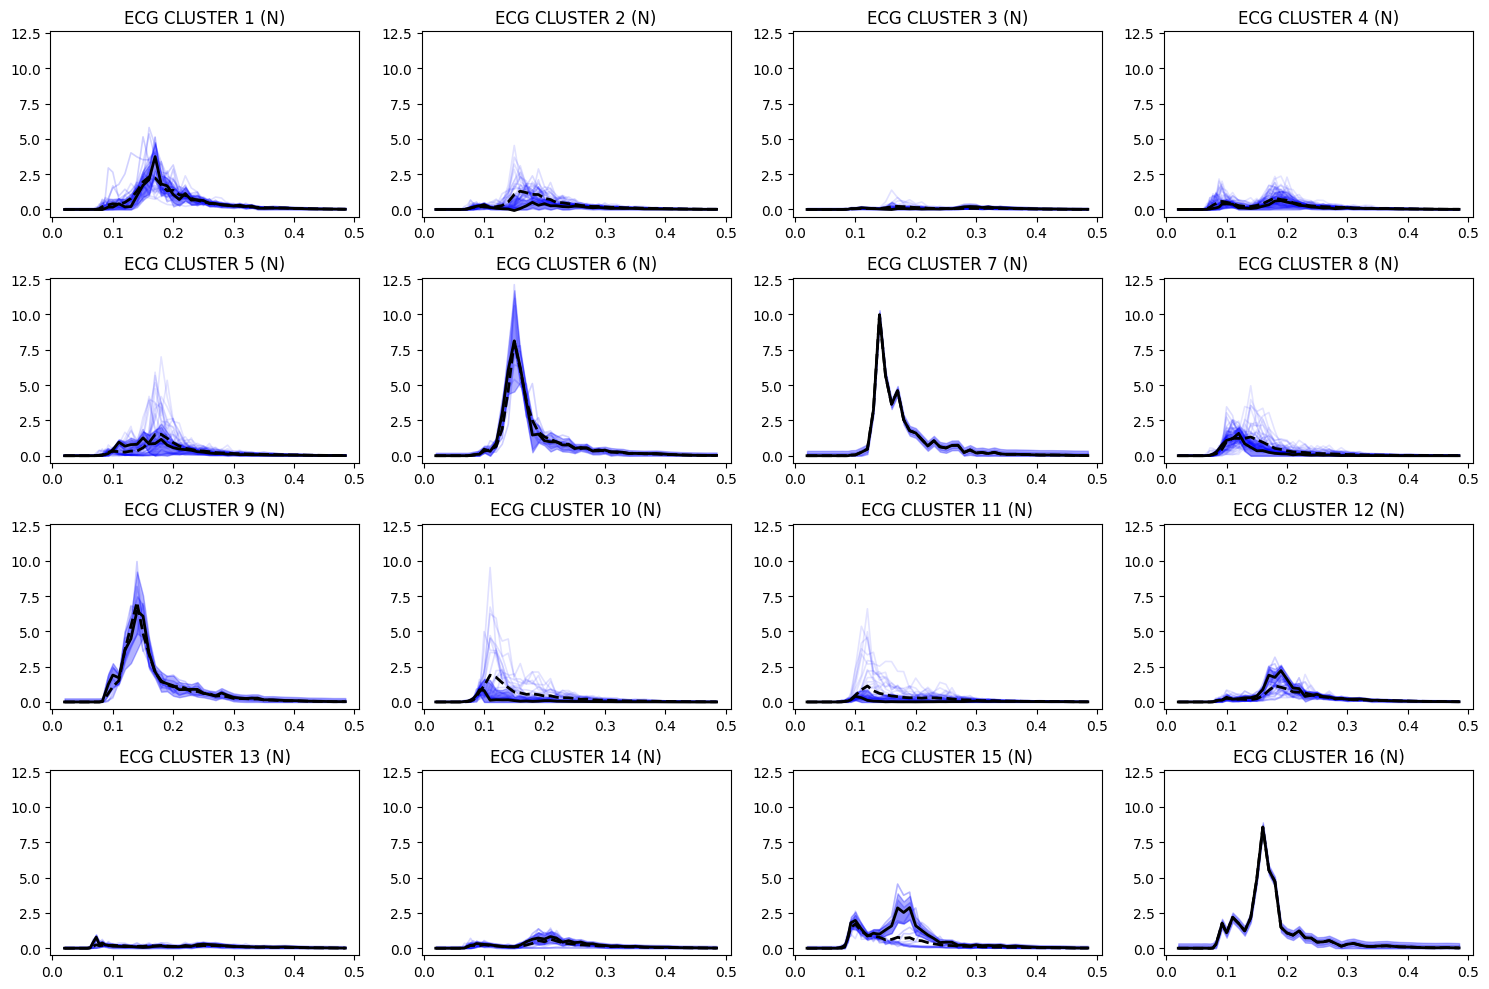

In [10]:
sw_gp_online = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=False, max_models=100, inducing_points=inducing_points, estimation_limit=None, annealing=False, free_deg_MNIV=5)

#Generate artificial labels to plot using util_plots.
from hdpgpc.util_plots import print_results, plot_models_plotly
num_samples = data.shape[0]
labels = np.array(['N'] * num_samples)
#mean_data = np.mean(data, axis=1)[:, np.newaxis]
#data_ = data - mean_data
for t in range(400):
    print("Sample: "+str(t))
    sw_gp_online.include_sample(x_train, data[t], with_warp=warp)
main_model = print_results(sw_gp_online, labels, 0, error=False)
selected_gpmodels = sw_gp_online.selected_gpmodels()
plot_models_plotly(sw_gp_online, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0], plot_latent=True, ticks=True, yscale=True)

In [11]:
sw_gp = hdpgp.GPI_HDP(x_basis=x_basis, x_basis_warp=x_basis_warp, n_outputs=1,
                          ini_lengthscale=ini_lengthscale, bound_lengthscale=bound_lengthscale,
                          ini_gamma=gamma, ini_sigma=sigma, ini_outputscale=outputscale_, noise_warp=noise_warp,
                          bound_sigma=bound_sigma, bound_gamma=bound_gamma, bound_noise_warp=bound_noise_warp,
                          verbose=False, max_models=100, inducing_points=inducing_points, reestimate_initial_params=False,
                          n_explore_steps=10, free_deg_MNIV=20)

#logdata = np.log(data + 1e-6)
x_trains = np.array([x_train] * num_samples)
sw_gp.include_batch(x_trains, data[:num_samples,:,[0]])

Group responsability estimated: [8160    0]
---Kernel estimated---
0.534**2 * RBF(length_scale=0.00906) + WhiteKernel(noise_level=0.00299)

-----------Lead 1-----------
Step 1/10- Trying to divide: 0 with beat 5688
---Kernel estimated---
1.45**2 * RBF(length_scale=0.00394) + WhiteKernel(noise_level=0.00305)

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------
Current resp: tensor([7973.7395,  189.0591])
ELBO_reduction: 69967.63442741125

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------
Current resp: tensor([7859.1714,  305.3344])
ELBO_reduction: 68783.12795930565

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------
Current resp: tensor([7772.8315,  396.4634])
ELBO_reduction: 54595.21952081192

-----------Lead 1-----------

   -----------Model 1-----------

   -----------Model 2-----------
Current resp: tensor([7683.3364,  496.9601])
ELBO_reduction: 2

In [77]:
from matplotlib.colors import to_hex
color = {0: 'k', 1: 'b', 2: 'r', 3: 'g', 4: 'c', 5: 'purple', 6: 'darkgreen', 7: 'maroon',
         8: 'orange', 9: 'lightgreen', 10: 'magenta', 11: 'lightblue', 12: 'darkblue', 13: 'red',
         14: 'red', 15: 'goldenrod', 16: 'red'}
labels_trans = {'N': 1, 'V': 2, 'R': 3, '!': 4, 'F': 5, 'L': 6, 'A': 7, '/': 8, 'Q': 9, 'f': 10, 'E': 11,
                'J': 12, 'j': 13, 'e': 14, 'a': 15, 'S': 16}
def plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0, title=None, save=None, lead=0, step=0.1, plot_latent=False, ticks=False, yscale=False):
    num_models = len(selected_gpmodels)
    num_cols = int(np.ceil(np.sqrt(num_models)))
    num_rows = int(np.ceil(num_models / num_cols))

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 20), squeeze=False)
    axes = axes.flatten()

    def col_fun(lab):
        if type(labels[0]) is np.int32:
            return to_hex(color.get(lab, 'b'))
        else:
            return to_hex(color.get(labels_trans.get(lab, 0), 'b'))

    for i, m in enumerate(selected_gpmodels):
        ax = axes[i]
        gp = sw_gp.gpmodels[lead][m]

        # Plot training data
        for j_, d in enumerate(gp.y_train):
            j = gp.indexes[j_]
            x_t = gp.x_train[j_].T[0]
            d = sw_gp.y_train[j,:,[lead]]
            if isinstance(d, torch.Tensor):
                d = d.detach().cpu()
                x_t = x_t.cpu()
            ax.plot(x_t, d.T[0], alpha=max(0.07, 0.5 / (np.log(len(gp.y_train) - j_ + 1) + 1)),
                    color=col_fun(labels[j + N_0]), linewidth=1.2)

        # Mean and variance
        x_b = gp.x_basis.T[0]
        if (x_b[1] - x_b[0]) == step:
            x_ = torch.clone(x_b)
        else:
            x_ = torch.arange(min(x_b), max(x_b), step, dtype=torch.float64).cpu()

        mean_, Sig_ = gp.observe_last(torch.atleast_2d(x_).T)
        #mean_l, Sig_l = gp.step_forward_last(torch.atleast_2d(x_).T)

        noise_ob = np.sqrt(np.diag(Sig_.cpu()))
        mean = mean_.cpu().T[0]
        neg_lim = mean - 1.9 * noise_ob
        neg_lim[neg_lim < 0.0] = 0.0
        ax.plot(x_, mean, color='black', linewidth=2, label=f'Emission GP mean [{m + 1}]')
        ax.fill_between(x_, neg_lim, mean + 1.9 * noise_ob, color=col_fun(main_model[i]), alpha=0.3)

        # Latent mean
        mean_latent = gp.f_star_sm[-1].cpu().T[0]
        noise_lat = 1.9 * np.sqrt(np.diag(gp.Gamma[-1].cpu()))
        neg_lim = mean_latent - noise_lat
        neg_lim[neg_lim < 0.0] = 0.0
        # ax.plot(x_b.cpu(), mean_latent, color='grey', linewidth=1.5, label=f'Latent GP Mean [{m + 1}]')
        ax.fill_between(x_b.cpu(), neg_lim, mean_latent+noise_lat, color=col_fun(main_model[i]), alpha=0.22)

        #Experimental mean
        mean = np.mean(np.array(gp.y_train), axis=0)
        ax.plot(x_b.cpu(), mean, color='black', linewidth=2, label=f'Experimental mean [{m + 1}]', linestyle='--')

        if title is None:
            ax.set_title(f"ECG CLUSTER {m + 1} ({main_model[m]})")
        else:
            ax.set_title(title)
        #ax.grid(True)
    if yscale:
        for ax in fig.get_axes():
            ax.set_ylim(np.min(sw_gp.y_train.numpy())-0.5, np.max(sw_gp.y_train.numpy()) + 0.5)
            ax.set_xticks(np.arange(0.0,0.5,0.1))
    if not ticks:
        for ax in fig.get_axes():
        #     ax.label_outer()
        #     ax.set_yticklabels([])
            ax.set_xticklabels([])
            ax.set_xticks([])
        #     ax.set_yticks([])
    # Hide unused subplots
    for j in range(len(axes)):
        if j >= num_models:
            axes[j].axis('off')

    fig.tight_layout()
    if save:
        plt.savefig(save)
    else:
        plt.show()

Model 1 : MainModel: N : [N-3303]
Model 2 : MainModel: N : [N-1588]
Model 3 : MainModel: N : [N-1371]
Model 4 : MainModel: N : [N-390]
Model 5 : MainModel: N : [N-381]
Model 6 : MainModel: N : [N-348]
Model 7 : MainModel: N : [N-288]
Model 8 : MainModel: N : [N-159]
Model 9 : MainModel: N : [N-110]
Model 10 : MainModel: N : [N-80]
Model 11 : MainModel: N : [N-62]
Model 12 : MainModel: N : [N-29]
Model 13 : MainModel: N : [N-16]
Model 14 : MainModel: N : [N-14]
Model 15 : MainModel: N : [N-8]
Model 16 : MainModel: N : [N-7]
Model 17 : MainModel: N : [N-6]
Classification error:  0.0 / 8160 -- 0.0


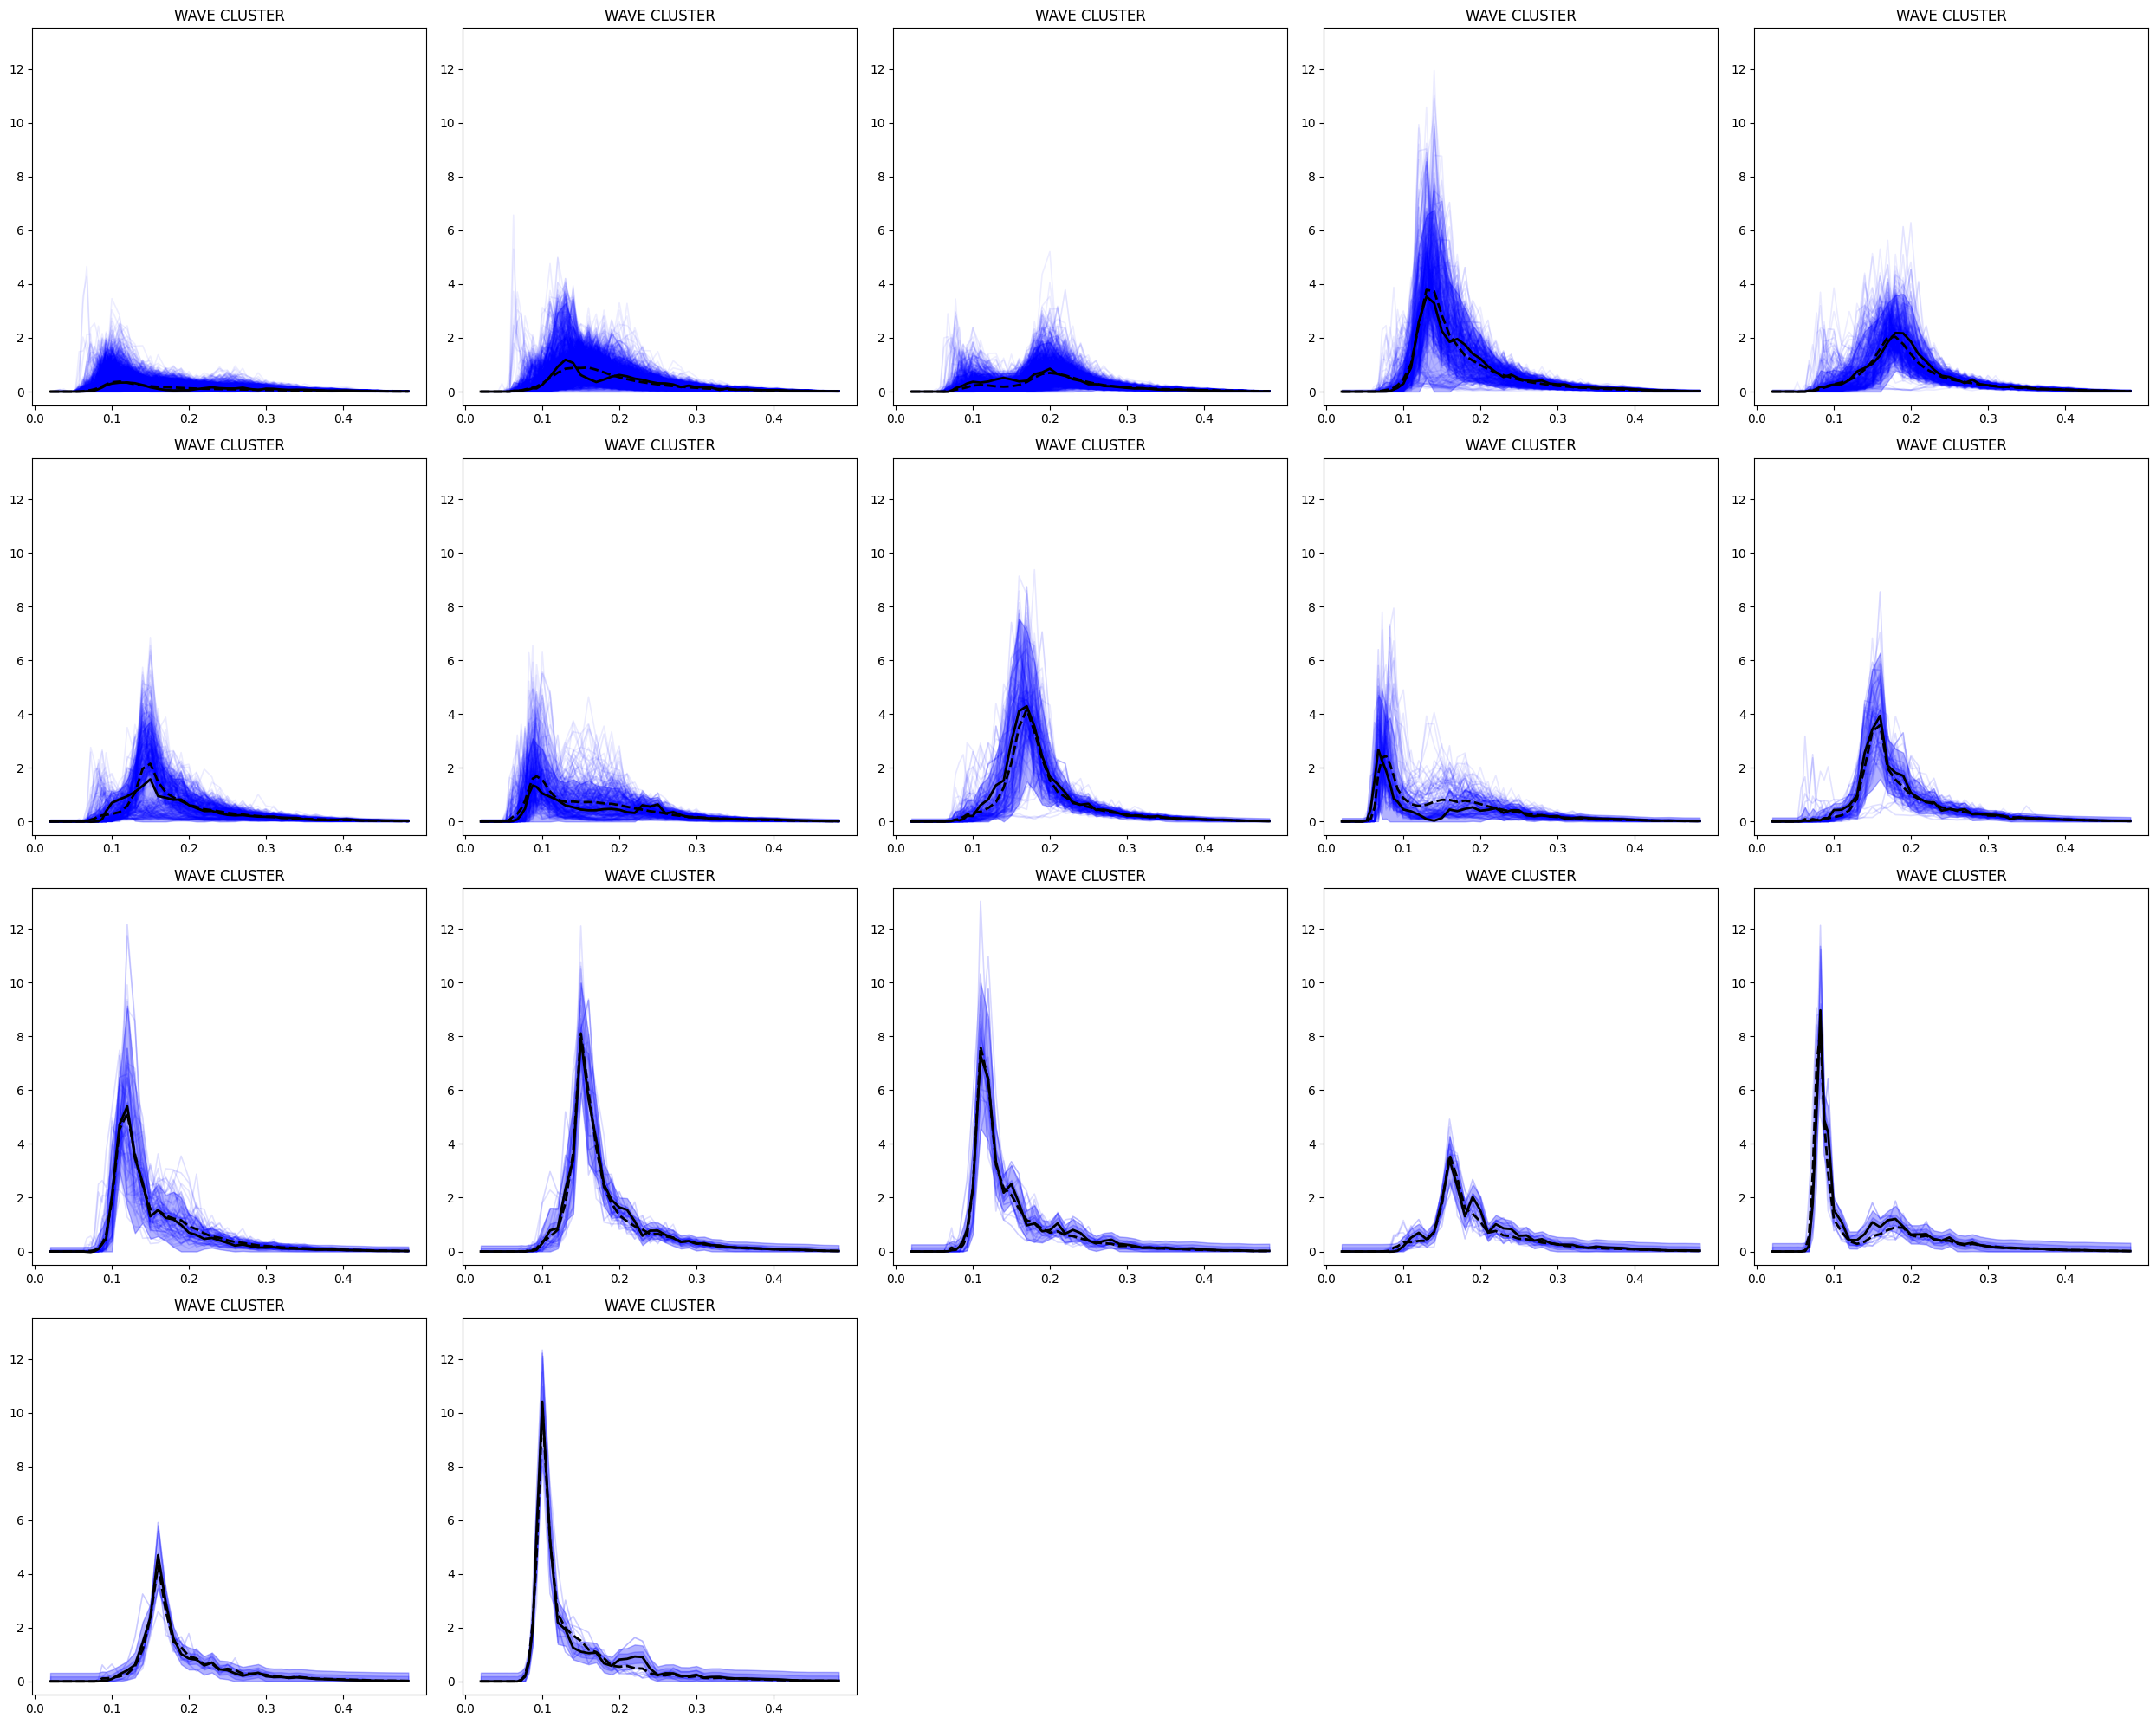

In [78]:
labels = np.array(['N'] * num_samples)
main_model = print_results(sw_gp, labels, 0, error=False)
selected_gpmodels = sw_gp.selected_gpmodels()
plot_models_plotly(sw_gp, selected_gpmodels, main_model, labels, N_0=0, lead=0, step=freq[1]-freq[0],
                   plot_latent=False, title='WAVE CLUSTER', ticks=True, yscale=True, save="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/clusters_ndbc.png")

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class FunctionEvolutionVisualizer:
    def __init__(self, gp, initial_step, num_steps):
        """
        Initialize the visualizer with required parameters.

        Parameters:
        - gp: GP_model.
        - initial_step: Initial time step for animation.
        - num_steps: Number of time steps to simulate.
        """
        self.gp = gp
        self.num_steps = num_steps
        self.initial_step = initial_step

        # Initialize figure and lines for animation
        self.fig, self.ax = plt.subplots(figsize=(8, 6))
        self.lines = {
            "prediction": self.ax.plot([], [], label="Predicted Mean", color="red")[0],
            "observation": self.ax.plot([], [], label="Observation", color="blue")[0],
            "correction": self.ax.plot([], [], label="Corrected Mean", color="green")[0],
        }

        # Add fill_between for variance band (initially empty)
        self.variance_band = None

        # Set plot properties
        self.ax.legend()
        self.ax.set_xlim(0.0, 0.5)
        self.ax.set_ylim(0.0, 7.0)
        self.ax.set_xlabel("Frequency (Hz)")
        self.ax.set_ylabel("Energy")
        self.ax.set_title("Function Evolution Over Time")

    def init_animation(self):
        """Initialize the animation by clearing all lines."""
        for line in self.lines.values():
            line.set_data([], [])

        # Clear the variance band if it exists
        if self.variance_band is not None:
            self.variance_band.remove()
            self.variance_band = None

        return list(self.lines.values())

    def animate(self, i):
        """
        Animation function for each frame.

        Parameters:
        - i: Current frame index.

        Steps:
        1. Show prediction.
        2. Show observation.
        3. Show correction.

        Each step is shown with a delay of half a second (500 ms).
        """
        # Determine which logical step (sub-frame) we are in
        step = i % 4  # Cycle through 0 (prediction), 1 (observation), 2 (correction)
        j = self.initial_step + i // 4  # Determine the actual time step

        if j >= len(self.gp.x_train):  # Stop if we exceed available data
            return list(self.lines.values())

        x_ = self.gp.x_train[j].T[0]

        if step == 0:  # First correction step
            if i == 0:
                # Initialize the current function for new animation
                self.current_function = self.gp.f_star[j].T[0].numpy().copy()
                self.lines["correction"].set_data(x_, self.current_function)
            # Update the title dynamically with the current time step
            self.ax.set_title(f"Function Evolution Over Time - Time Step: {j}")

            # Clear observation and correction temporarily
            self.lines["observation"].set_data([], [])
            self.lines["prediction"].set_data([], [])
            # Clear observation and prediction temporarily
            if self.variance_band is not None:
                self.variance_band.remove()
                self.variance_band = None

        elif step == 1:  # Prediction step

            predicted_f = np.linalg.matrix_power(self.gp.A[j].numpy(),20) @ self.current_function
            self.lines["prediction"].set_data(x_, predicted_f)

            variance = np.sqrt(torch.diag(self.gp.Gamma[j]).numpy()) * 1.96
            # Update variance band dynamically
            if self.variance_band is not None:
                self.variance_band.remove()  # Remove the old band
            lower_bound = predicted_f - variance
            upper_bound = predicted_f + variance
            self.variance_band = self.ax.fill_between(x_, lower_bound, upper_bound, color="red", alpha=0.2)

        elif step == 2:  # Observation step

            observed_f = self.gp.y_train[j].T[0].numpy()
            self.lines["observation"].set_data(x_, observed_f)

        elif step == 3:

            corrected_f = self.gp.f_star[j + 1].T[0].numpy().copy()
            self.lines["correction"].set_data(x_, corrected_f)

            # Update current function for the next iteration
            self.current_function = corrected_f

        return list(self.lines.values())

    def create_animation(self, output_filename="function_evolution.gif"):
        """
        Create and save the animation as a GIF.

        Parameters:
          - output_filename: Name of the output GIF file.

        Returns:
          None
          (The GIF will be saved to disk.)
        """

        ani = animation.FuncAnimation(
            self.fig,
            func=self.animate,
            init_func=self.init_animation,
            frames=self.num_steps,
            interval=400,
            blit=False,
            repeat=False,
        )

        ani.save(output_filename, writer="pillow")

GIF saved as 'function_evolution.gif'


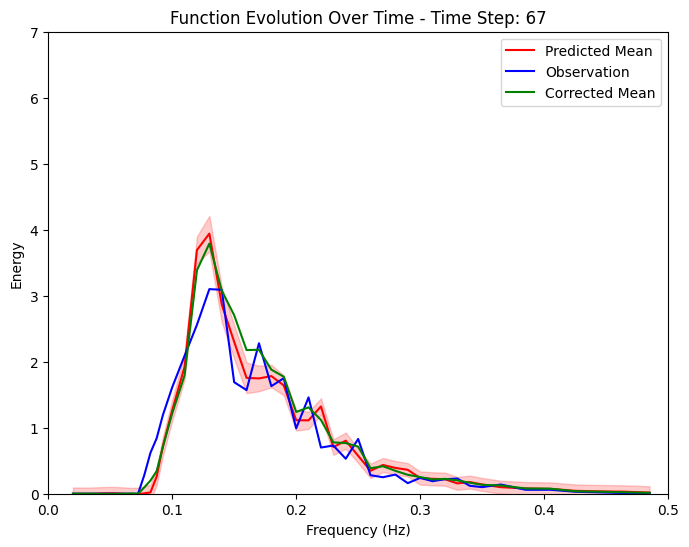

In [96]:
gp = sw_gp.gpmodels[0][3]
initial_step = 53
num_steps = 15 * 4  # Number of time steps to simulate

# Create visualizer instance
visualizer = FunctionEvolutionVisualizer(gp, initial_step, num_steps)

# Generate animation and save as GIF
visualizer.create_animation(output_filename="/home/adrian.perez/Documents/OceanWave/HDP-GPC/hdpgpc/ocean/function_evolution.gif")
print("GIF saved as 'function_evolution.gif'")